In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch as t
from torch.utils import data
from torchvision import transforms as tsf

TRAIN_PATH = './train.pth'
TEST_PATH = './test.tph'
%matplotlib inline


import os
from pathlib import Path
from PIL import Image
from skimage import io
import numpy as np
from tqdm import tqdm
import torch as t


def process(file_path, has_mask=True):
    file_path = Path(file_path)
    files = sorted(list(Path(file_path).iterdir()))
    datas = []

    for file in tqdm(files):
        item = {}
        imgs = []
        for image in (file/'images').iterdir():
            img = io.imread(image)
            imgs.append(img)
        assert len(imgs)==1
        if img.shape[2]>3:
            assert(img[:,:,3]!=255).sum()==0
        img = img[:,:,:3]

        if has_mask:
            mask_files = list((file/'masks').iterdir())
            masks = None
            for ii,mask in enumerate(mask_files):
                mask = io.imread(mask)
                assert (mask[(mask!=0)]==255).all()
                if masks is None:
                    H,W = mask.shape
                    masks = np.zeros((len(mask_files),H,W))
                masks[ii] = mask
            tmp_mask = masks.sum(0)
            assert (tmp_mask[tmp_mask!=0] == 255).all()
            for ii,mask in enumerate(masks):
                masks[ii] = mask/255 * (ii+1)
            mask = masks.sum(0)
            item['mask'] = t.from_numpy(mask)
        item['name'] = str(file).split('/')[-1]
        item['img'] = t.from_numpy(img)
        datas.append(item)
    return datas

# You can skip this if you have alreadly done it.
test = process('./data/stage1_test/',False)
t.save(test, TEST_PATH)
train_data = process('./data/stage1_train/')

import PIL
class Dataset():
    def __init__(self,data,source_transform,target_transform):
        self.datas = data
#         self.datas = train_data
        self.s_transform = source_transform
        self.t_transform = target_transform
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        mask = data['mask'][:,:,None].byte().numpy()
        img = self.s_transform(img)
        mask = self.t_transform(mask)
        return img, mask
    def __len__(self):
        return len(self.datas)
s_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize((128,128)),
    tsf.ToTensor(),
    tsf.Normalize(mean = [0.5,0.5,0.5],std = [0.5,0.5,0.5])
]
)
t_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize((128,128),interpolation=PIL.Image.NEAREST),
    tsf.ToTensor(),]
)
dataset = Dataset(train_data,s_trans,t_trans)
dataloader = t.utils.data.DataLoader(dataset,num_workers=2,batch_size=4)

100%|██████████| 670/670 [01:51<00:00,  6.02it/s]


In [2]:
%matplotlib notebook

import sys, os

# Use second GPU -- change if you want to use a first one
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

import models.fcn as fcns
from transforms import (ComposeJoint,
                        RandomHorizontalFlipJoint,
                                                       RandomScaleJoint,
                                                       CropOrPad,
                                                       ResizeAspectRatioPreserve)

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision.transforms as transforms

from matplotlib import pyplot as plt

import numpy as np
from PIL import Image

from sklearn.metrics import confusion_matrix

# Helper functions to be able to get mask-out values out of training

def flatten_logits(logits, number_of_classes):
    """Flattens the logits batch except for the logits dimension"""
    
    logits_permuted = logits.permute(0, 2, 3, 1)
    logits_permuted_cont = logits_permuted.contiguous()
    logits_flatten = logits_permuted_cont.view(-1, number_of_classes)
    
    return logits_flatten


In [14]:

def flatten_annotations(annotations):
    
    return annotations.view(-1)

def get_valid_annotations_index(flatten_annotations, mask_out_value=255):
    
    return torch.squeeze( torch.nonzero((flatten_annotations != mask_out_value )), 1)

number_of_classes = 21

labels = range(number_of_classes)

train_transform = ComposeJoint(
                [
                    RandomHorizontalFlipJoint(),
                    #[ResizeAspectRatioPreserve(greater_side_size=348),
                    # ResizeAspectRatioPreserve(greater_side_size=348, interpolation=Image.NEAREST)],
                    # RandomScaleJoint(low=0.9, high=1.1),
                    # [CropOrPad(output_size=(348, 348)), CropOrPad(output_size=(348, 348), fill=255)],
                     [transforms.ToTensor(), None],
                     [transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), None],
                     [None, transforms.Lambda(lambda x: torch.from_numpy(np.asarray(x)).long()) ]
                ])



# Define the validation function to track MIoU during the training
def validate():
    
    fcn.eval()
    
    overall_confusion_matrix = None

    for image, annotation in dataloader:

        image = Variable(image)
        logits = fcn(image)

        # First we do argmax on gpu and then transfer it to cpu
        logits = logits.data
        _, prediction = logits.max(1)
        prediction = prediction.squeeze(1)

        prediction_np = prediction.cpu().numpy().flatten()
        annotation_np = annotation.numpy().flatten()

        # Mask-out value is ignored by default in the sklearn
        # read sources to see how that was handled

        current_confusion_matrix = confusion_matrix(y_true=annotation_np.round(),
                                                    y_pred=prediction_np.round(),
                                                    labels=labels)

        if overall_confusion_matrix is None:


            overall_confusion_matrix = current_confusion_matrix
        else:

            overall_confusion_matrix += current_confusion_matrix
    
    
    intersection = np.diag(overall_confusion_matrix)
    ground_truth_set = overall_confusion_matrix.sum(axis=1)
    predicted_set = overall_confusion_matrix.sum(axis=0)
    union =  ground_truth_set + predicted_set - intersection

    intersection_over_union = intersection / union.astype(np.float32)
    mean_intersection_over_union = np.mean(intersection_over_union)
    
    fcn.train()

    return mean_intersection_over_union



<IPython.core.display.Javascript object>


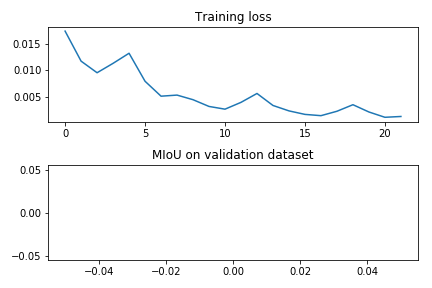

In [15]:

# Create the training plot
loss_current_iteration = 0
loss_history = []
loss_iteration_number_history = []

validation_current_iteration = 0
validation_history = []
validation_iteration_number_history = []

f, (loss_axis, validation_axis) = plt.subplots(2, 1)

loss_axis.plot(loss_iteration_number_history, loss_history)
validation_axis.plot(validation_iteration_number_history, validation_history)
loss_axis.set_title('Training loss')
validation_axis.set_title('MIoU on validation dataset')

plt.tight_layout()

In [5]:
## Define the model and load it to the gpu
fcn = fcns.FCN_32s(num_classes=2)


## Define the loss and load it to gpu

criterion = nn.CrossEntropyLoss(size_average=False)

optimizer = optim.Adam(fcn.parameters(), lr=0.000001, weight_decay=0.0005)



In [17]:
best_validation_score = 0

for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    
    for i, data in enumerate(dataloader, 0):
        
        # get the inputs
        img, anno = data
        
        # We need to flatten annotations and logits to apply index of valid
        # annotations. All of this is because pytorch doesn't have tf.gather_nd()
        anno_flatten = flatten_annotations(anno)
        index = get_valid_annotations_index(anno_flatten, mask_out_value=512)
        anno_flatten_valid = torch.index_select(anno_flatten, 0, index)

        # wrap them in Variable
        # the index can be acquired on the gpu
        img, anno_flatten_valid, index = Variable(img), Variable(anno_flatten_valid).long(), Variable(index)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        logits = fcn(img)
        logits_flatten = flatten_logits(logits, number_of_classes=2)
        logits_flatten_valid = torch.index_select(logits_flatten, 0, index)
        
        loss = criterion(logits_flatten_valid, anno_flatten_valid)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += (loss.data[0] / logits_flatten_valid.size(0)) 
        if i % 20 == 19:
            
            
            loss_history.append(running_loss / 20)
            loss_iteration_number_history.append(loss_current_iteration)
            
            loss_current_iteration += 1
            
            loss_axis.lines[0].set_xdata(loss_iteration_number_history)
            loss_axis.lines[0].set_ydata(loss_history)

            loss_axis.relim()
            loss_axis.autoscale_view()
            loss_axis.figure.canvas.draw()
            
            running_loss = 0.0
        
        
            
    current_validation_score = validate()
    validation_history.append(current_validation_score)
    validation_iteration_number_history.append(validation_current_iteration)

    validation_current_iteration += 1

    validation_axis.lines[0].set_xdata(validation_iteration_number_history)
    validation_axis.lines[0].set_ydata(validation_history)

    validation_axis.relim()
    validation_axis.autoscale_view()
    validation_axis.figure.canvas.draw()

    # Save the model if it has a better MIoU score.
    if current_validation_score > best_validation_score:

        torch.save(fcn.state_dict(), 'fcn_32s_newbest.pth')
        best_validation_score = current_validation_score
            
            

print('Finished Training')

/afs/inf.ed.ac.uk/user/s17/s1777953/miniconda3/envs/mlp/lib/python3.6/site-packages/torch/nn/functional.py:1423: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.")


Finished Training


/afs/inf.ed.ac.uk/user/s17/s1777953/miniconda3/envs/mlp/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in true_divide


In [18]:
best_validation_score

0

In [19]:
class TestDataset():
    def __init__(self,path,source_transform):
        self.datas = t.load(path)
        self.s_transform = source_transform
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        img = self.s_transform(img)
        return img
    def __len__(self):
        return len(self.datas)

testset = TestDataset(TEST_PATH, s_trans)
testdataloader = t.utils.data.DataLoader(testset,num_workers=2,batch_size=2)

In [33]:
for i, data in enumerate(testdataloader, 0):
        
        # get the inputs
    img= Variable(data)
    res=fcn(img)
    _, tmp = res.squeeze(0).max(0)

    segmentation = tmp.data.cpu().numpy().squeeze()

    plt.imshow(img)
    plt.show()

    plt.imshow(segmentation)
    plt.show()
    break

/afs/inf.ed.ac.uk/user/s17/s1777953/miniconda3/envs/mlp/lib/python3.6/site-packages/torch/nn/functional.py:1423: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.")


TypeError: Image data cannot be converted to float